In [1]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


# Loading data

In [2]:
#Importing the data, creating X + y and checking shape
data = pd.read_csv('data/train.csv', index_col='Id')
X = data.drop(columns='SalePrice')
y = data['SalePrice']

X.shape, y.shape


((1460, 79), (1460,))

## 🐣 1. BASELINE

### 1.1 Initial feature overview

In [65]:
#Checking the value counts of each columns dtype
X.dtypes.value_counts()


object     43
int64      33
float64     3
dtype: int64

How many unique categories are there in total?

In [5]:
#Creating a dataframe only object dtypes
df_cat_only = X[make_column_selector(dtype_include='object')]

#Creating a list of the nunique values in the category dataframe
feat_categorical_nunique_list = []
for i in df_cat_only.columns:
    cat_num = df_cat_only[i].nunique()
    feat_categorical_nunique_list.append(cat_num)

#Turning the above list into a series
feat_categorical_nunique = pd.Series(feat_categorical_nunique_list, dtype='float64')
cat_names = pd.Series(df_cat_only.columns)

#Total amount of unique categories
feat_categorical_nunique.sum()


252.0

In [9]:
nunique_cat_df = pd.concat([cat_names, feat_categorical_nunique], axis=1)
nunique_cat_df


,0,1
0,MSZoning,5.0
1,Street,2.0
2,Alley,2.0
3,LotShape,4.0
4,LandContour,4.0
5,Utilities,2.0
6,LotConfig,5.0
7,LandSlope,3.0
8,Neighborhood,25.0
9,Condition1,9.0


We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

(array([18., 16.,  4.,  2.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

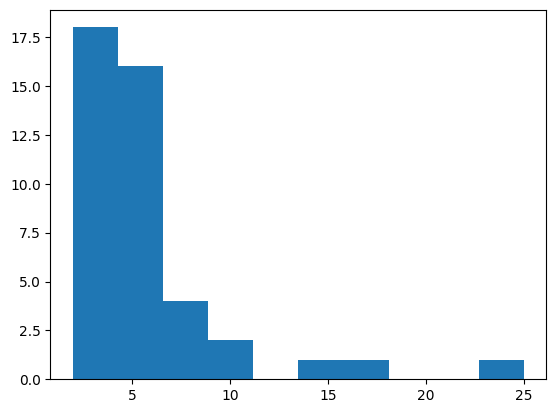

In [68]:
#Plotting a hist of unique categories
plt.hist(feat_categorical_nunique_list)


In [11]:
#Creating a list of large and small categories that we will either drop or adjust
feat_categorical_small = nunique_cat_df[nunique_cat_df[1] < 7][0]
feat_categorical_large = nunique_cat_df[nunique_cat_df[1] > 6][0]


### 1.2 Baseline pipe

#### a) Preprocessing

In [13]:
X_small_cats = X.drop(columns=feat_categorical_large)

#Checking missing values in the dataframe
d_types = X_small_cats.dtypes
empty = X_small_cats.isna().sum()
df_with_nan = pd.concat([d_types, empty], axis=1)
df_with_nan.sort_values(1, ascending=False)


,0,1
PoolQC,object,1453
MiscFeature,object,1406
Alley,object,1369
Fence,object,1179
FireplaceQu,object,690
...,...,...
CentralAir,object,0
MSZoning,object,0
2ndFlrSF,int64,0
LowQualFinSF,int64,0


In [14]:
#Making Column transformers
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))

#Isolating columns
num_cols = make_column_selector(dtype_include=['float64', 'int64'])
# cat_cols = make_column_selector(dtype_include=['object'])
cat_cols = list(feat_categorical_small)

#Instantiating the pipeline
preproc_baseline = make_column_transformer((num_transformer, num_cols),
                                                 (cat_transformer, cat_cols))


In [15]:
preproc_baseline.fit(X)


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [17]:
X_preproc = pd.DataFrame(preproc_baseline.transform(X))
X_preproc


,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
shape_preproc_baseline = X_preproc.shape
shape_preproc_baseline


(1460, 183)

#### b) Adding estimator

In [27]:
decision_tree = DecisionTreeRegressor()

pipe_basline = make_pipeline(preproc_baseline, decision_tree)


#### c) Cross-Validate

[Contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 

Using make_scorer to create custom scoring metrics
We need rmsle and rmsle_neg - this is for grid searching

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [28]:
def rmsle_func(y, y_pred):
    return np.sqrt(np.sum((np.log(1+y) - np.log(1+y_pred))**2))

def neg_rmsle_func(y, y_pred):
    tot = np.sqrt(np.sum((np.log(1+y) - np.log(1+y_pred))**2))
    return tot * -1


In [29]:
# Testing fucntions
neg_rmsle_func(1300, 1500), rmsle_func(1300, 1500)


(-0.14299835312095688, 0.14299835312095688)

In [30]:
pipe_basline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [32]:
rmsle = make_scorer(rmsle_func)
neg_rmsle = make_scorer(neg_rmsle_func)

params = {'decisiontreeregressor__max_depth':[3, 7, 11, 14, 25],
          'decisiontreeregressor__min_samples_leaf': [10, 20, 50, 75, 100],
          'decisiontreeregressor__min_samples_split': [3, 5, 7, 10, 20, 50]
         }


In [33]:
search = GridSearchCV(pipe_basline, param_grid=params, scoring=neg_rmsle, cv=5, n_jobs=1)


In [34]:
search


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=1,
             param_grid={'decisiontreeregressor__max_depth': [3, 7, 11, 14, 25],
                         'decisiontreeregressor__min_samples_leaf': [10, 20, 50,
                                                                     75, 100],
                         'decisiontreeregressor__min_samples_split': [3, 5, 7,
                                                                      10, 20,
                                                                      50]},
             scoring=make_scorer(neg_rmsle_func))

In [36]:
search.fit(X, y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=1,
             param_grid={'decisiontreeregressor__max_depth': [3, 7, 11, 14, 25],
                         'decisiontreeregressor__min_samples_leaf': [10, 20, 50,
                                                                     75, 100],
                         'decisiontreeregressor__min_samples_split': [3, 5, 7,
                                                                      10, 20,
                                                                      50]},
             scoring=make_scorer(neg_rmsle_func))

In [37]:
search.best_estimator_


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1714427a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, min_samples_leaf=10,
                                       min_samples_split=20))])

In [38]:
score_baseline = search.best_score_
score_baseline


-3.1662180878731916

In [41]:
best_mod = search.best_estimator_


#### d) Predict baseline

In [42]:
test_data = pd.read_csv('data/test.csv', index_col='Id')


In [43]:
y_pred_baseline = best_mod.predict(test_data)


In [44]:
#Creating a dataframe in the format Kaggle requires
baseline_df = pd.DataFrame(y_pred_baseline)
test_ind_df = pd.DataFrame(test_data.index)

submission_df = pd.concat([test_ind_df, baseline_df], axis=1)


In [48]:
submission_df.rename(columns={0:'SalePrice'}, inplace=True)


In [49]:
submission_df


,Id,SalePrice
0,1461,136263.636364
1,1462,163400.000000
2,1463,177693.750000
3,1464,179662.500000
4,1465,226686.444444
...,...,...
1454,2915,84875.000000
1455,2916,92729.411765
1456,2917,111460.000000
1457,2918,114940.000000


In [113]:
# Saving as CSV ready for submission
example = pd.read_csv('data/sample_submission.csv')
submission_df.to_csv('data/submission_baseline.csv', index=False)


## 🏋️‍♀️ 2. ITERATIONS 

### 2.1 Preprocessing Iteration ♲

#### a) Ordinal Encoding (1h)

In [ ]:
feat_ordinal_dict = {
    # Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [ ]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)


In [ ]:
# Define nominal features to one-hot-encode as the remaining ones (non-numerical, non-ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


In [ ]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [ ]:
pd.DataFrame(preproc.fit_transform(X,y)).head()


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


#### b) Statistical Feature Selection

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!


##### <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

In [ ]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4cbfd8d00>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x7fb44b81bf70>))])

In [ ]:
preproc.fit_transform(X, y).shape


(1460, 54)

#### d) Treat Cyclical features

Transfrom time based features to cyclical features?

In [ ]:
# Treat cyclical features
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


#### e) Target engineering (15 min)

We are asked to minimize the RMS**L**E. Lets transform our target to directly predict its `log`?

Text(0.5, 0, 'log(SalePrice)')

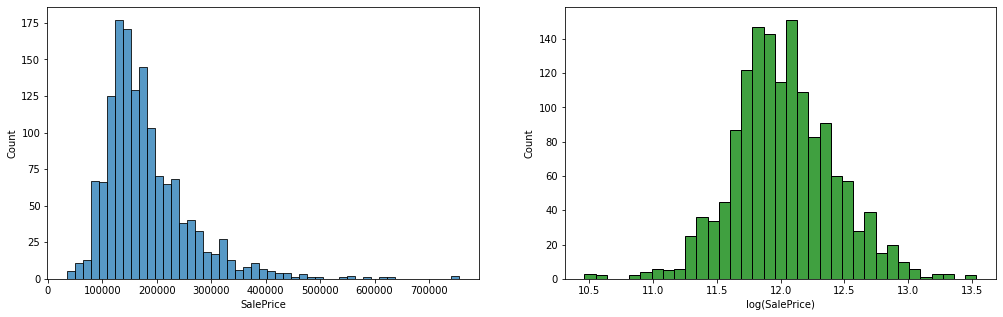

In [ ]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.histplot(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')

plt.xlabel("log(SalePrice)")


In [ ]:
# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)


### 2.2 Model Iteration ♻

#### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be and then try many model types to find the best one possible (you can try grid search or go model by model).

In [ ]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4cbdec340>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7fb44b81bf70>))])

In [ ]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)

preproc_fitted_log.transform(X).shape


(1460, 108)

In [ ]:
# SOLUTION
allow_grid_searching = True # Use True to activate GridSearch in the notebook cells below

# Cache the preprocessing step of the pipeline
cachedir = mkdtemp()


#### b) Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor, etc.)

In [ ]:
# Ridge with normal target
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()


0.1690305858952616

In [ ]:
# Ridge with log-target (much better)
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()


0.14077207391563823

In [ ]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5, 2, num=20)}

    search_ridge = GridSearchCV(
        pipe_ridge,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_ridge.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_ridge.best_params_}')
    print(f'Best score 👉 {search_ridge.best_score_}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................ridge__alpha=0.5; total time=   0.4s
[CV] END ...................................ridge__alpha=0.5; total time=   0.5s
[CV] END ...................................ridge__alpha=0.5; total time=   0.4s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   0.4s
[CV] END ...................................ridge__alpha=0.5; total time=   0.4s
[CV] END ...................................ridge__alpha=0.5; total time=   0.5s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   0.4s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   0.5s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   0.5s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   0.5s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   0.5s
[CV] END ....................ridge__alpha=0.578

#### c) KNN

In [ ]:
model = KNeighborsRegressor()

pipe_knn = make_pipeline(preproc, model)


In [ ]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()


0.2014095334106189

In [ ]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}

    search_knn = GridSearchCV(
        pipe_knn,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_knn.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_knn.best_params_}')
    print(f'Best score 👉 {search_knn.best_score_}')


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] END .................kneighborsregressor__n_neighbors=3; total time=   2.2s
[CV] END .................kneighborsregressor__n_neighbors=5; total time=   2.5s
[CV] END .................kneighborsregressor__n_neighbors=4; total time=   2.8s
[CV] END .................kneighborsregressor__n_neighbors=3; total time=   3.2s
[CV] END .................kneighborsregressor__n_neighbors=4; total time=   3.5s
[CV] END .................kneighborsregressor__n_neighbors=5; total time=   3.7s
[CV] END .................kneighborsregressor__n_neighbors=4; total time=   3.8s
[CV] END .................kneighborsregressor__n_neighbors=3; total time=   4.1s
[CV] END .................kneighborsregressor__n_neighbors=6; total time=   2.2s
[CV] END .................kneighborsregressor__n_neighbors=6; total time=   2.9s
[CV] END .................kneighborsregressor__n_neighbors=7; total time=   2.2s
[CV] END .................kneighborsregressor__n

#### d) SVM

In [ ]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()


0.13853792865320455

In [ ]:
model = SVR(kernel='rbf', C = 10)

pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()


0.13667096295313644

In [ ]:
# GridSearch
if allow_grid_searching:
    param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm_rbf = GridSearchCV(
        pipe_svm_rbf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm_rbf.fit(X, y_log);

    svm_rbf_best = search_svm_rbf.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_svm_rbf.best_params_}')
    print(f'Best score 👉 {search_svm_rbf.best_score_}')


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   0.7s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   0.6s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   0.6s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   0.7s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.9s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.9s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.9s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   1.0s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.5s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.5s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   0.5s
[CV] END ......................svr__C=0.5, svr_

#### e) Trees

In [ ]:
model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.010026893027705628
0.18889941289621864


#### f) Random Forest

In [ ]:
# TODO: GridSearch

model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.007255771629969681
0.1622864278544527


#### g) Boosted Trees

In [ ]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.01068473791418105
0.14231917402589617


In [ ]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.00934941012148608
0.12785608675652832


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END gradientboostingregressor__max_features=17, gradientboostingregressor__n_estimators=299; total time=   0.5s
[CV] END gradientboostingregressor__max_features=17, gradientboostingregressor__n_estimators=299; total time=   0.5s
[CV] END gradientboostingregressor__max_features=17, gradientboostingregressor__n_estimators=299; total time=   0.5s
[CV] END gradientboostingregressor__max_features=17, gradientboostingregressor__n_estimators=299; total time=   0.5s
[CV] END gradientboostingregressor__max_features=17, gradientboostingregressor__n_estimators=299; total time=   0.5s
[CV] END gradientboostingregressor__max_features=18, gradientboostingregressor__n_estimators=141; total time=   0.3s
[CV] END gradientboostingregressor__max_features=18, gradientboostingregressor__n_estimators=141; total time=   0.3s
[CV] END gradientboostingregressor__max_features=18, gradientboostingregressor__n_estimators=141; total time=   0.3s
[CV]

/home/bruncky/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bruncky/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bruncky/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/bruncky/.pyenv/versions/3.8.12/envs/lewago


----------------------------------------

Best params 👉 {'gradientboostingregressor__max_features': 38, 'gradientboostingregressor__n_estimators': 266}
Best score 👉 -0.12487178938977794


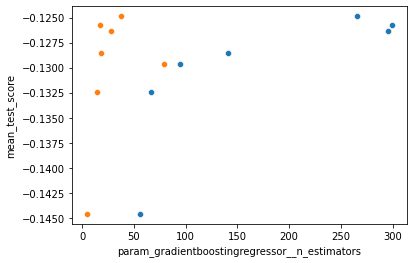

In [ ]:
if allow_grid_searching:
     grid = {
          'gradientboostingregressor__n_estimators': stats.randint(50,300),
          # 'gradientboostingregressor__learning_rate': stats.uniform(0.05, 0.3),
          # 'gradientboostingregressor__loss': ['lad', 'huber', 'quantile'],
          # 'gradientboostingregressor__max_depth': stats.randint(3, 5),
          # 'gradientboostingregressor__min_samples_split': stats.randint(2, 10),
          # 'gradientboostingregressor__subsample': [0.95, 1], # 1 default
          'gradientboostingregressor__max_features': stats.randint(0.9, len(X.columns)) # default None, i.e = n_features
     }

     search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2)

     # Fit data to GridSearch
     search_gb.fit(X, y_log);

     print('\n----------------------------------------\n')
     print(f'Best params 👉 {search_gb.best_params_}')
     print(f'Best score 👉 {search_gb.best_score_}')

     # Plot results of GridSearch
     df_cv_results_ = pd.DataFrame(search_gb.cv_results_)

     sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
     sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)


#### h) Stacking

In [ ]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    weights = [1, 1, 1, 1], # to equally weight the models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


0.011434823963532991
0.12323946887251762


In [ ]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


0.011559337093034845
0.12176414428263616


#### i) XGBoost

In [ ]:
# Create eval test just for early-stopping purposes (XGBOOST and Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)


In [ ]:
# Instantiate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)


In [ ]:
# Option 1: Integrate XGB into Sklearn's pipeline
# It allows you to GridSearchCV its best hyperparams
pipe_xgb = make_pipeline(preproc, model_xgb)

cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()


0.1349798122575569

Best Validation Score 0.143374


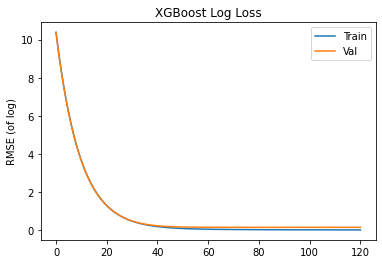

In [ ]:
# Option 2: Use XGBoost Library to fit it
# It allows you to use an `early_stopping` criteria with a Train/Val slit
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb.fit(
    X_train_preproc,
    y_train_log,
    verbose=False,
    eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
    eval_metric=["rmse"],
    early_stopping_rounds=10
)

# Retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# Plot RMSLE loss
fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))


## working area

In [176]:
forest_params = {'randomforestregressor__n_estimators': [75, 120, 150],
                 'randomforestregressor__max_depth':[40, 50, 60],
                 'randomforestregressor__min_samples_split': [2, 3, 7]}


In [177]:
forest = RandomForestRegressor()

preprocess = make_column_transformer((num_transformer, num_cols),
                                                 (cat_transformer, cat_cols))

forest_pipe = make_pipeline(preprocess, forest)

forest_search = GridSearchCV(forest_pipe, param_grid=forest_params, scoring=neg_rmsle, cv=5, n_jobs=4)


In [178]:
forest_pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15204b6a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('randomforestregressor', RandomForestRegressor())])

In [179]:
forest_search.fit(X, y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15204b6a0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'randomforestregressor__max_depth': [40, 50, 60],
                         'randomforestregressor__min_samples_split': [2, 3, 7],
                         'randomforestregressor__n_estimators': [75, 120, 150]},
             scoring=make_scorer(neg_rmsle_func))

In [180]:
forest_search.best_params_, forest_search.best_score_


({'randomforestregressor__max_depth': 40,
  'randomforestregressor__min_samples_split': 2,
  'randomforestregressor__n_estimators': 150},
 -2.488123727864026)

({'randomforestregressor__max_depth': 50,
  'randomforestregressor__min_samples_split': 3,
  'randomforestregressor__n_estimators': 120},
 -2.4908327374548813)

({'randomforestregressor__max_depth': 50,
  'randomforestregressor__min_samples_leaf': 10,
  'randomforestregressor__min_samples_split': 3,
  'randomforestregressor__n_estimators': 75},
 -2.6362181544716785)

In [183]:
for_pred = forest_search.predict(test_data)


In [184]:
for_df = pd.DataFrame(for_pred)
test_ind_df = pd.DataFrame(test_data.index)

for_submission_df = pd.concat([test_ind_df, for_df], axis=1)

for_submission_df.rename(columns={0:'SalePrice'}, inplace=True)


In [186]:
for_submission_df.to_csv('data/submission_ant.csv', index=False)


In [216]:
# x_params = {'xbgregressor__n_estimators': [75, 120, 150],
#             'xbgregressor__max_depth':[40, 50, 60],
#             'xbgregressor__learning_rate': [0.01, 0.1, 1]}

xgb_reg = XGBRegressor(max_depth=50, learning_rate=0.1, n_estimators=200)

xgb_pipe = make_pipeline(preprocess, xgb_reg)

# xgb_search = GridSearchCV(xgb_reg, param_grid=x_params, scoring=neg_rmsle, cv=5, n_jobs=4)

x_cross = cross_validate(xgb_pipe, X, y, scoring=neg_rmsle, cv=5, n_jobs=2)


In [217]:
x_cross['test_score'].mean()


-2.3519304509286543

In [221]:
xgb_pipe.fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15204b6a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=50, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [224]:
x_pred = xgb_pipe.predict(test_data)


In [225]:
x_df = pd.DataFrame(x_pred)
test_ind_df = pd.DataFrame(test_data.index)

x_submission_df = pd.concat([test_ind_df, x_df], axis=1)

x_submission_df.rename(columns={0:'SalePrice'}, inplace=True)


In [227]:
x_submission_df.to_csv('data/submission_x.csv', index=False)


In [156]:
# rand_forest_params = {'randomforestregressor__n_estimators': (stats.uniform(30, 120)),
#                  'randomforestregressor__max_depth':stats.uniform(75, 125),
#                  'randomforestregressor__min_samples_split': stats.uniform(1, 30)}

# rand_forest = RandomForestRegressor()

# preprocess = make_column_transformer((num_transformer, num_cols),
#                                                  (cat_transformer, cat_cols))

# rand_forest_pipe = make_pipeline(preprocess, rand_forest)

# rand_forest_search = RandomizedSearchCV(rand_forest_pipe, rand_forest_params, scoring=neg_rmsle,
#                                    n_iter=15, cv=5, n_jobs=4)


In [170]:
# rand_forest_search.fit(X, y)
